In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

In [24]:
class Loan:

    @staticmethod
    def get_recurring_payment_c(*, n, p, r):
        return p * (r * (1 + r)**n) / ((1 + r)**n - 1)
    
    @staticmethod
    def get_current_rate_r(*, k, r, Rs: pd.DataFrame | None, month):
        if Rs is not None:
            rel_Rs = Rs[month >= Rs['month']]['rate']
            if len(rel_Rs) > 0:
                R = rel_Rs.iloc[-1]
                r = R / k
        return r
    
    @staticmethod
    def get_accumulated_offset_o(*, Os: pd.DataFrame | None, month):
        o = 0
        if Os is not None:
            rel_Os = Os[month >= Os['month']]['amount']
            if len(rel_Os) > 0:
                o = rel_Os.sum()
        return o

    def __init__(self, *, N, k, P, R0):
        self.N = N
        self.k = k
        self.P = P
        self.R0 = R0
        
        self.n = self.N * self.k
        self.r0 = self.R0 / self.k
        self.c0 = self.get_recurring_payment_c(n=self.n, p=self.P, r=self.r0)
        self.m0 = self.c0 * self.k / 12
    
    def print(self):
        print('--- Configuration ---')
        print('Term length N:', self.N, 'yrs')
        print('Payments per year k:', self.k)
        print('Principal P:', self.P)
        print('Initial interest R0:', self.R0 * 100, '% pa')
        print('')
        print('--- Analysis ---')
        print('Initial payment per month m0:', f'{self.m0:.2f}')
        print('Initial total amount to be paid:', f'{(self.n * self.c0):.2f}')
        print('Initial total interest to be paid: ', f'{(self.n * self.c0 - self.P):.2f}', f'({((self.n * self.c0 - self.P) / (self.n * self.c0) * 100):.2f}', '%)')
        print('')

    def simulate(self, *,  Rs=None, Es=None):
        plan = []

        p = self.P
        r = self.r0
        o = 0
        i = 0
        while p > o:
            prev_i_month = (i - 1) * 12 / self.k
            curr_i_month = (i) * 12 / self.k

            r = self.get_current_rate_r(r=r, k=self.k, Rs=Rs, month=prev_i_month)
            c = self.get_recurring_payment_c(n=self.n - i, p=p, r=r)

            prev_o = self.get_accumulated_offset_o(Os=Es, month=prev_i_month)
            o = self.get_accumulated_offset_o(Os=Es, month=curr_i_month)
            o_paid = prev_o - prev_o

            i += 1
            curr_year = i / self.k

            total_paid = c
            interest_paid = (p - o) * r
            principal_paid = total_paid - interest_paid
            p -= principal_paid

            plan.append((i, curr_i_month, curr_year, interest_paid, principal_paid, o_paid, p, curr_i_o))
        
        plan = pd.DataFrame(plan, columns=['i', 'month', 'year', 'interest', 'principal', 'offset', 'remaining', 'accumulated_offset'])
        plan.set_index('i', drop=False, inplace=True)

        print('--- Simulation ---')
        display(plan.head(5))
        display(plan.tail(5))

        return plan

In [25]:
P = 1100000
N = 20
k = 12
R0 = 0.065

Rs = []
#Rs.append((24, 0.085))
#Rs.append((48, 0.065))
Rs = pd.DataFrame(Rs, columns=['month', 'rate'])
Rs.set_index('month', drop=False, inplace=True)

Os = []
Os.append((12, 100000))
Os = pd.DataFrame(Os, columns=['month', 'amount'])
Os.set_index('month', drop=False, inplace=True)

In [26]:
myLoan1 = Loan(N=N, k=k, P=P, R0=R0)
myLoan1.print()
plan1 = myLoan1.simulate()

--- Configuration ---
Term length N: 20 yrs
Payments per year k: 12
Principal P: 1100000
Initial interest R0: 6.5 % pa

--- Analysis ---
Initial payment per month m0: 8201.30
Initial total amount to be paid: 1968313.08
Initial total interest to be paid:  868313.08 (44.11 %)



NameError: name 'e' is not defined

In [ ]:
myLoan2 = Loan(N=N, k=k, P=P, R0=R0)
myLoan2.print()
plan2 = myLoan2.simulate(Rs=Rs, Es=Os)

--- Configuration ---
Term length N: 20 yrs
Payments per year k: 12
Principal P: 1100000
Initial interest R0: 6.5 % pa

--- Analysis ---
Initial payment per month m0: 8201.30
Initial total amount to be paid: 1968313.08
Initial total interest to be paid:  868313.08 (44.11 %)

--- Simulation ---


,i,month,year,interest,principal,offset,remaining
i,,,,,,,
1,1,0.0,0.083333,5958.333333,2242.971157,0,1.097757e+06
2,2,1.0,0.166667,5946.183906,2255.120584,0,1.095502e+06
3,3,2.0,0.250000,5933.968670,2267.335821,0,1.093235e+06
4,4,3.0,0.333333,5921.687267,2279.617223,0,1.090955e+06
5,5,4.0,0.416667,5909.339341,2291.965150,0,1.088663e+06


,i,month,year,interest,principal,offset,remaining
i,,,,,,,
236,236,235.0,19.666667,198.171923,7238.276598,0,2.934731e+04
237,237,236.0,19.750000,158.964591,7277.483930,0,2.206983e+04
238,238,237.0,19.833333,119.544887,7316.903634,0,1.475292e+04
239,239,238.0,19.916667,79.911659,7356.536862,0,7.396385e+03
240,240,239.0,20.000000,40.063751,7396.384770,0,-5.638867e-11


In [ ]:
def plot(ax1, plan: pd.DataFrame):
    ax2 = ax1.twinx()
    # axis 1

    ax1.plot(plan['year'], plan['remaining'], 'k-', label='remaining')

    principal_half = plan.loc[plan['remaining'] <= 0.5 * plan['remaining'].iloc[0]].iloc[0]
    ax1.axhline(y=principal_half['remaining'], color='y', linestyle='-')
    ax1.axvline(x=principal_half['year'], color='y', linestyle='-')

    ax1.set_xlabel('Years')
    ax1.set_ylabel('Remaining')
    ax1.legend(loc='lower left')

    # axis 2

    ax2.plot(plan['year'], plan['interest'], 'r--', label='interest')
    ax2.plot(plan['year'], plan['principal'], 'g--', label='principal')
    ax2.plot(plan['year'], plan['interest'] + plan['principal'], 'b--', label='interest + principal')

    interest_principal_turnover = plan.loc[plan['principal'] >= plan['interest']].iloc[0]
    ax2.axhline(y=interest_principal_turnover['principal'], color='y', linestyle='--')
    ax2.axvline(x=interest_principal_turnover['year'], color='y', linestyle='--')

    ax2.set_ylabel('Payments')
    ax2.legend(loc='center right')

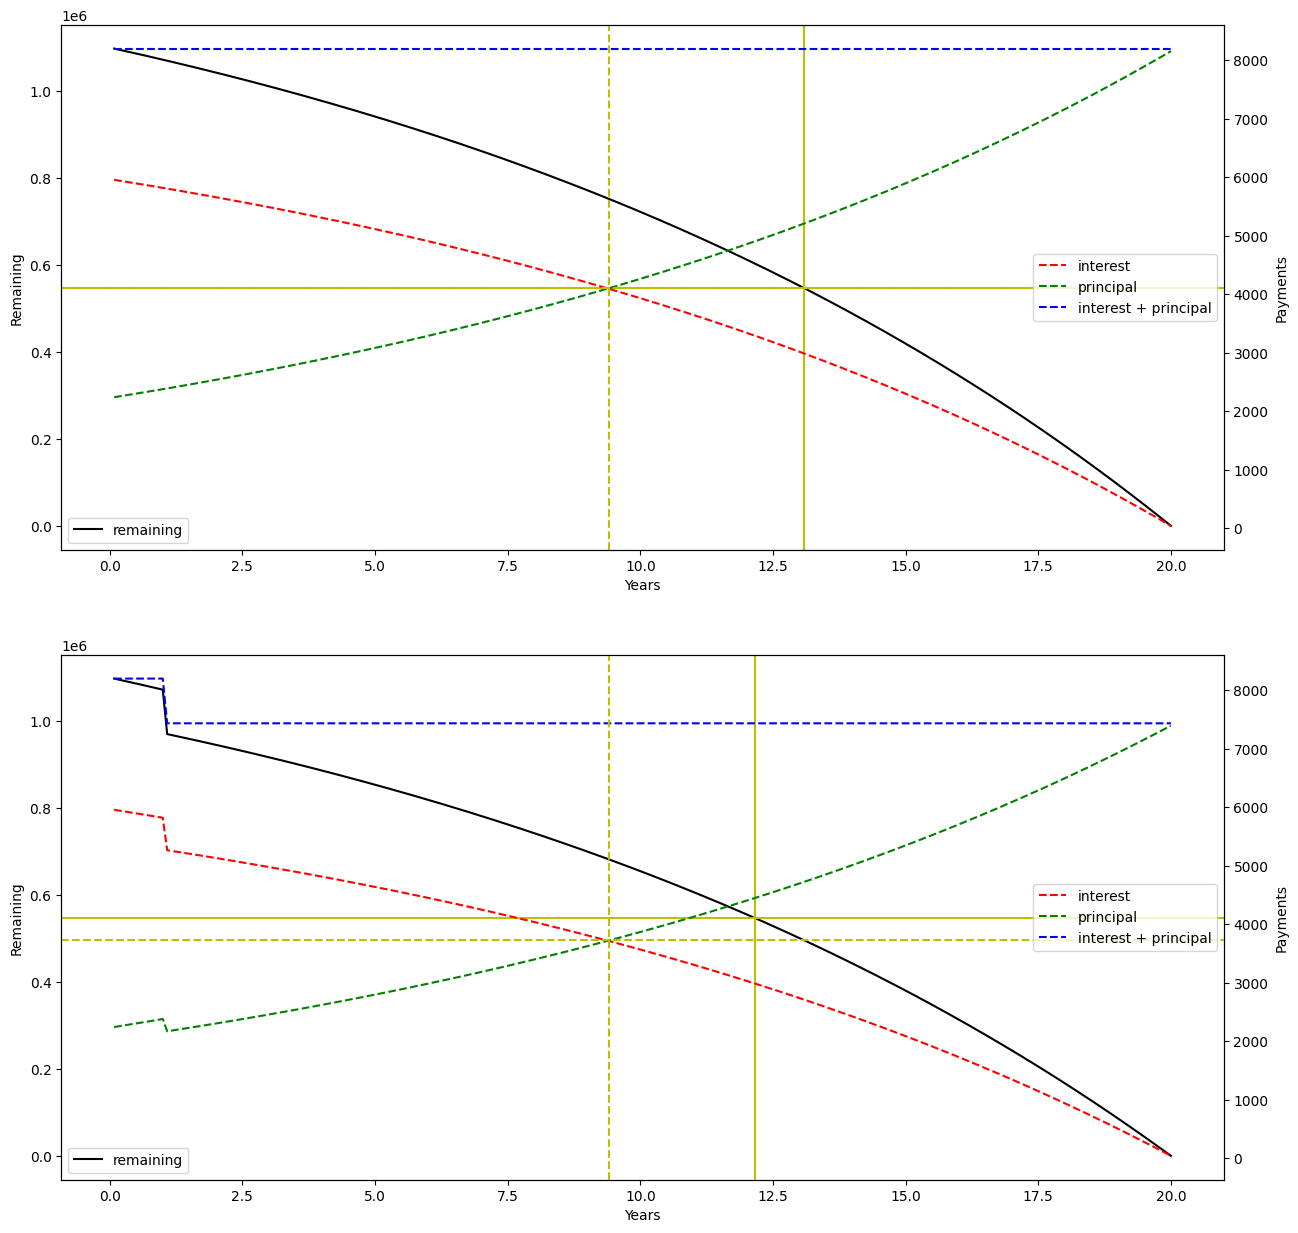

In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(15,15))

plot(axs[0], plan1)
plot(axs[1], plan2)

axs[1].set_xlim(axs[0].get_xlim())

plt.show()